In [ ]:
#Install dependencies
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116 torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install transformers requests beautifulsoup4 pandas numpy
!pip install ipywidgets
!pip install datasets
!pip install evaluate

In [ ]:
#Import dependencies
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from google.colab import files
import lxml.html
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import evaluate




In [ ]:
# we prepare our device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# upload our files
#uploaded = files.upload()

In [ ]:
df_train = pd.read_csv("train.csv")
df_train = df_train[:-1]
df_train.columns = ['text', 'label']

df_train = df_train.astype({'label' : int})
df_test = pd.read_csv("test.csv")
df_test.columns = ['text', 'label']

df_test = df_test.astype({'label' : int})

df_train.head()

,text,label
0,carefully word blog posts amount criticism hea...,0
1,cannot remember little mermaid feeling carefre...,1
2,not feeling super well turns cold knocked next...,1
3,feel honored part group amazing talents,1
4,think helping also began feel pretty lonely lo...,0


In [ ]:
# a little bit of preprocessing
import re
def f_preprocess_text(text):

  pattern = r"(?:\b\w+\b|['\"“”‘’])"
  url = re.compile(r'http\S+|www\S+')
  ponct = re.compile(r'[^\w\s]')
  digit = re.compile(r'\d+')
  non_ascii = re.compile(r'[^\x00-\x7F]+')


  text = text.replace("\'", "")
  text = text.replace("\n", "")
  text = text.replace("<br />", "")

  # enlver les site webs
  text = url.sub('', text)
  # enlever ponctuation
  text = ponct.sub('', text)
  # enlever les digits
  text = digit.sub('', text)
  # enlever non-ASCII
  text = non_ascii.sub('', text)

  # enlever les charcteres uniques
  words = [word for word in re.findall(pattern, text) if len(word) > 1]
  text = " ".join(words)
  return text

df_train['text'] = df_train['text'].apply(f_preprocess_text)
df_test['text'] = df_test['text'].apply(f_preprocess_text)

df_train['text'].tolist()[:5]

['carefully word blog posts amount criticism hear place coming saudis non saudis goes show feeling discontent lot areas directed towards specific people never swat teams charging conversations',
 'cannot remember little mermaid feeling carefree beauty life gets lost somewhere massive piles homework budgeting finances eventually daunting choices life become adult',
 'not feeling super well turns cold knocked next three weeks afterward hotter know head not',
 'feel honored part group amazing talents',
 'think helping also began feel pretty lonely lot people used enjoy climbing moved really feel like anyone climb hard gym anymore']

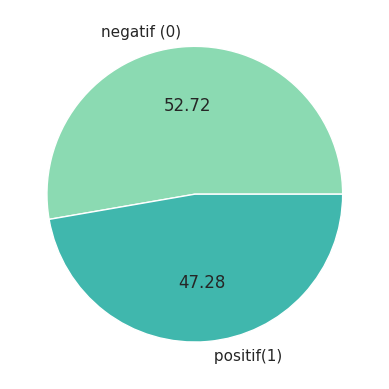

In [ ]:
#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
#Setting a color palette
palette=sns.color_palette('mako_r')
sns.set(palette=palette)
plt.pie(df_train['label'].value_counts(), labels=['negatif (0)',' positif(1)'],autopct="%0.2f")
plt.show()

#Modèle Transformers

---



*   Élément de liste
*   Élément de liste




In [ ]:
## function for sentiment prediction with a model, a tokenizer and some data

def compute_metrics_trainer(eval_pred):
    metric = evaluate.load("accuracy")
    x= eval_pred
    logits = torch.tensor(x[0])
    labels = x[1]
    predictions = torch.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}



def f_predict_sentiment_review(model, tokenizer, review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    result = int(torch.argmax(result.logits))
    return (result)

def f_predict_sentiment_dataset(dataset, model, tokenizer):
  dataset['prediction'] = dataset['text'].apply(lambda x: f_predict_sentiment_review(model, tokenizer, x[:512]))
  return(dataset)

def f_tokenize_text(examples, tokenizer):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512, return_tensors="tf")

def f_tokenize_data_from_df(df, tokenizer):
  dataset = Dataset.from_pandas(df)
  tokenized_dataset = dataset.map(f_tokenize_text, batched=True, fn_kwargs = {'tokenizer' : tokenizer})
  return(tokenized_dataset)
################################################################################
def f_test_model_hf(model_name, name_new_model) :
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
  model.to(device)
  Train, Test = train_test_split(df_train, test_size=0.25, random_state=0)

  tokenized_train = f_tokenize_data_from_df(Train, tokenizer)
  tokenized_test = f_tokenize_data_from_df(Test, tokenizer)

  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  training_args = TrainingArguments(
    output_dir="./results",    
    num_train_epochs=4,    # 4          
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,  
    learning_rate=2e-5,
    warmup_steps=1000, # 1000
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True,
    weight_decay=0.01)

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train,
      eval_dataset=tokenized_test,
      tokenizer=tokenizer,
      data_collator=data_collator,
      compute_metrics = compute_metrics_trainer,
  )

  trainer.train()

  trainer.save_model(name_new_model)

  tokenizer2 = AutoTokenizer.from_pretrained(name_new_model)
  model2 = AutoModelForSequenceClassification.from_pretrained(name_new_model)

  df_test_prediction = f_predict_sentiment_dataset(df_test, model2, tokenizer2)

  metrics = compute_metrics(df_test_prediction['label'], df_test_prediction['prediction'])


  return([df_test_prediction, metrics, model_name])

In [ ]:
# resultats des model pre-entraines directement sur notre jeu de test

Train, Test = train_test_split(df_train, test_size=0.25, random_state=0)

for model_name in ['siebert/sentiment-roberta-large-english', 'distilroberta-base', 'distilbert-base-uncased-finetuned-sst-2-english', 'distilbert-base-uncased'] :
  print(model_name)

  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
  df_test_prediction = f_predict_sentiment_dataset(df_test, model, tokenizer)

  metrics = compute_metrics(df_test_prediction['label'], df_test_prediction['prediction'])
  print(metrics)
  print('------------------------------------------------------')

siebert/sentiment-roberta-large-english


{'accuracy': 0.7748117243573879, 'precision': 0.7950508052809843, 'recall': 0.7716355829867168, 'f1': 0.7831682157083035}
------------------------------------------------------
distilroberta-base


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

{'accuracy': 0.5270303716013153, 'precision': 0.5270303716013153, 'recall': 1.0, 'f1': 0.690268355368265}
------------------------------------------------------
distilbert-base-uncased-finetuned-sst-2-english


{'accuracy': 0.7536329243715306, 'precision': 0.8463350785340314, 'recall': 0.6506775794981886, 'f1': 0.7357202457710689}
------------------------------------------------------
distilbert-base-uncased


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

{'accuracy': 0.4965526995014673, 'precision': 0.5130922938012797, 'recall': 0.8768281229035287, 'f1': 0.6473662052056762}
------------------------------------------------------


In [ ]:
#Here we can test different model directly and then, with all our pre-defined function, it gives us our desired results
#resultats = f_test_model_hf('distilroberta-base', 'test_model')

#resultats

In [ ]:
#print(resultats[2], ' a comme score : ', resultats[1])